In [9]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
import random
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib
matplotlib.use('Agg')
from matplotlib import gridspec
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.font_manager as font_manager
import copy 
font_dirs = ['/project/elkabetz_lab_data/tools/PythonFonts/', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
matplotlib.rcParams['font.family'] = 'tahoma'
%matplotlib inline
import seaborn as sns

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


In [2]:
# Load organoid data

adata_dict = {}
line_ = 'FOK1'
adata_dict[line_] = {}
for tx in ['sbnx','sbn']:
    print('loading: ',tx)
    pkl_file = open('/project/elkabetz_lab_data/sequencing/scrna/d50_organoids_exp3/analysis/data/'+line_+'/d50_'+tx+'.pkl', 'rb')
    adata_dict[line_][tx] = pkl.load(pkl_file)
    adata_dict[line_][tx].obs['line'] = [line_ for x in range(len(adata_dict[line_][tx].obs))]
    pkl_file.close()

line_ = 'KUCG2'
adata_dict[line_] = {}
for tx in ['sbnx','sbn']:
    print('loading: ',tx)
    pkl_file = open('/project/elkabetz_lab_data/sequencing/scrna/d50_organoids_exp3/analysis/data/'+line_+'/d50_'+tx+'.pkl', 'rb')
    adata_dict[line_][tx] = pkl.load(pkl_file)
    adata_dict[line_][tx].obs['line'] = [line_ for x in range(len(adata_dict[line_][tx].obs))]
    pkl_file.close()

line_ = 'zip13k5'
adata_dict[line_] = {}
for tx in ['sbnx','sbn','nt']:
    print('loading: ',tx)
    pkl_file = open('/project/elkabetz_lab_data/sequencing/scrna/d50_organoids_exp2/analysis/data/'+line_+'/d50_'+tx+'.pkl', 'rb')
    adata_dict[line_][tx] = pkl.load(pkl_file)
    adata_dict[line_][tx].obs['line'] = ['zip13k5' for x in range(len(adata_dict[line_][tx].obs))]
    pkl_file.close()

line_ = 'zip8k8'
adata_dict[line_] = {}
for tx in ['sbnx','sbn','nt']:
    print('loading: ',tx)
    pkl_file = open('/project/elkabetz_lab_data/sequencing/scrna/d50_organoids_exp2/analysis/data/'+line_+'/d50_'+tx+'.pkl', 'rb')
    adata_dict[line_][tx] = pkl.load(pkl_file)
    adata_dict[line_][tx].obs['line'] = ['zip8k8' for x in range(len(adata_dict[line_][tx].obs))]
    pkl_file.close()

adata_merged = adata_dict['zip13k5']['sbnx'].concatenate(adata_dict['zip13k5']['sbn'],adata_dict['zip13k5']['nt'],
    adata_dict['zip8k8']['sbnx'],adata_dict['zip8k8']['sbn'],adata_dict['zip8k8']['nt'],adata_dict['FOK1']['sbnx'],
    adata_dict['FOK1']['sbn'],adata_dict['KUCG2']['sbnx'],adata_dict['KUCG2']['sbn'])


loading:  sbnx
loading:  sbn
loading:  sbnx
loading:  sbn
loading:  sbnx
loading:  sbn
loading:  nt
loading:  sbnx
loading:  sbn
loading:  nt


In [3]:
genes = list(adata_merged.var_names)
mito_genes = [gene for gene in genes if gene[:3] == 'MT-' or (gene[:2] == 'MT' and '.' in gene)]
rb_genes = [gene for gene in genes if gene[:3] in ['RNR','RPL','RPS','MRP'] or (gene[:2] == 'RP' and '.' in gene)]
adata_merged.obs['n_counts'] = adata_merged.X.sum(axis=1)
y=adata_merged.X > 0
adata_merged.obs['n_genes'] = y.sum(axis=1)
adata_merged.obs['percent_mito'] = np.sum(adata_merged[:, mito_genes].X, axis=1) / np.sum(adata_merged.X, axis=1)
adata_merged.obs['percent_ribo'] = np.sum(adata_merged[:, rb_genes].X, axis=1) / np.sum(adata_merged.X, axis=1)
print('n cells before filter:',len(adata_merged.obs['n_counts']))
sub_cells = adata_merged.obs[(adata_merged.obs['n_counts'] < 10000) & (adata_merged.obs['percent_mito'] < 0.4)]
print('n cells after filter:',len(sub_cells))
adata_merged = adata_merged[sub_cells.index,:]
adata_merged.obs['Index'] = range(len(adata_merged.obs))

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


n cells before filter: 96484
n cells after filter: 96454


In [24]:
info = pd.read_csv('/project/elkabetz_lab_data/sequencing/scrna/analysis/merged_d50_10x_v2/data/cell_identity.removed_doublets.tsv',sep='\t')
info.index = info['cell_id']
info = info.drop('cell_id',axis=1)
adata_merged.obs = info.loc[adata_merged.obs.index]

#remove doublets
adata_merged = adata_merged[adata_merged.obs['cell_type'] != 'doublet']
y=np.sum(adata_merged.X,axis=0)
adata_merged = adata_merged[:,y>0]


line_ = 'merged_no_doublets'

#normalize item number values to colormap
cell_type_class_color_dict = {}
cell_type_class_color_dict['Retinal'] = 'gold'
cell_type_class_color_dict['Cortical'] = 'royalblue'
cell_type_class_color_dict['Medial Pallium'] = 'indianred'
cell_type_class_color_dict['Posterior'] = 'limegreen'
cell_type_class_color_dict['Non-neural'] = 'violet'
cell_type_class_color_dict['Unknown'] = 'grey'

adata_merged_no_doublets = adata_merged[adata_merged.obs['cell_type']!='doublet']

In [30]:
cell_type_class_dict = {}
for cell_type in set(adata_merged_no_doublets.obs['cell_type']):
    if 'Cortical' in cell_type: cell_type_class_dict[cell_type]='Cortical'
    elif 'PNS' in cell_type or 'Posterior' in cell_type or 'Schwann' in cell_type: cell_type_class_dict[cell_type]='Posterior'
    elif 'Hippocampal' in cell_type or 'Choroid' in cell_type or 'Cajal' in cell_type: cell_type_class_dict[cell_type]='Medial Pallium'
    elif 'Retinal' in cell_type in cell_type: cell_type_class_dict[cell_type]='Retinal'
    elif 'Unknown' in cell_type in cell_type: cell_type_class_dict[cell_type]='Unknown'
    elif cell_type !='doublet': cell_type_class_dict[cell_type]='Non-neural'

cell_type_class_dict['doublet']='doublet'

adata_merged_no_doublets.obs['cell_type_class'] = [cell_type_class_dict[x] for x in adata_merged_no_doublets.obs['cell_type']]

Trying to set attribute `.obs` of view, copying.


In [31]:
perc_cells_per_tx = {}
for tx in ['sbnx','sbn','nt']:
    if tx == 'nt': lines = ['zip8k8','zip13k5']
    else: lines = ['FOK1','KUCG2','zip8k8','zip13k5']
    for line in lines:
        if line not in perc_cells_per_tx: perc_cells_per_tx[line] = {}
        perc_cells_per_tx[line][tx] = {}

regs = ['Cortical','Posterior','Medial Pallium','Retinal','Non-neural','Unknown']
for kk,reg in enumerate(regs):
    for j,tx in enumerate(['sbnx','sbn','nt']):
        if tx == 'nt': lines = ['zip8k8','zip13k5']
        else: lines = ['FOK1','KUCG2','zip8k8','zip13k5']
        for k,line_iter in enumerate(lines):
            adata_merged_sub = adata_merged_no_doublets[adata_merged_no_doublets.obs['line']==line_iter]
            len_tx = float(len(adata_merged_sub.obs[adata_merged_sub.obs['tx']==tx]))
            for clust in [reg]:#ordered_cell_type_class:
                perc_cells_per_tx[line_iter][tx][reg] = len(adata_merged_sub.obs[(adata_merged_sub.obs['tx']==tx) & (adata_merged_sub.obs['cell_type_class']==clust)])/len_tx


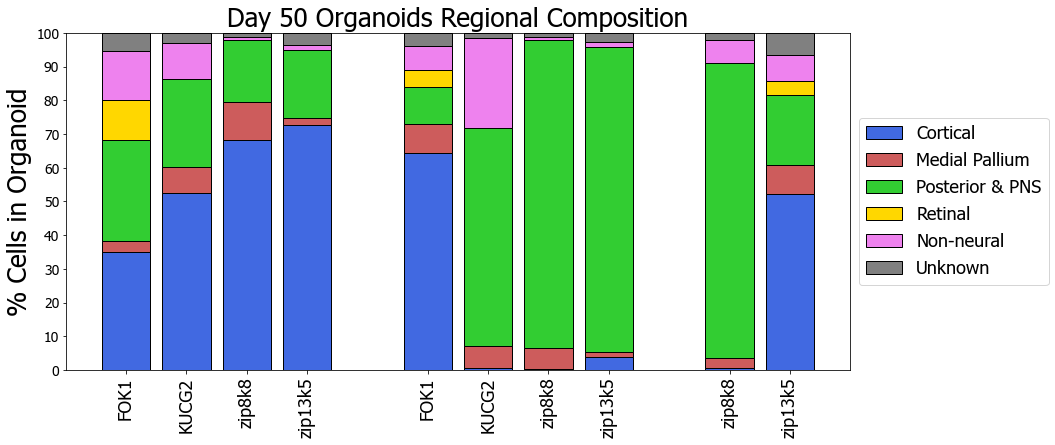

In [32]:
plt.figure(figsize=(12,6))
ax = plt.subplot(111)
regs = ['Cortical','Medial Pallium','Posterior','Retinal','Non-neural','Unknown']
bottoms = {}
for kk,reg in enumerate(regs):
    xticks = []
    xtick_locs = []
    x_iter = 0
    for j,tx in enumerate(['sbnx','sbn','nt']):
        if tx == 'nt': txs = ['zip8k8','zip13k5']
        else: txs = ['FOK1','KUCG2','zip8k8','zip13k5']
        for k,line_iter in enumerate(txs):
            if line_iter not in bottoms: 
                bottoms[line_iter]={}
            if tx not in bottoms[line_iter]:
                bottoms[line_iter][tx] = 0
            adata_merged_sub = adata_merged_no_doublets[adata_merged_no_doublets.obs['line']==line_iter]
            len_tx = float(len(adata_merged_sub.obs[adata_merged_sub.obs['tx']==tx]))
            for clust in [reg]:#ordered_cell_type_class:
                perc_cells = len(adata_merged_sub.obs[(adata_merged_sub.obs['tx']==tx) & (adata_merged_sub.obs['cell_type_class']==clust)])/len_tx
                plt.bar(x_iter+k,perc_cells,bottom=bottoms[line_iter][tx],color=cell_type_class_color_dict[clust],width=0.8,edgecolor='black',linewidth=1)
                bottoms[line_iter][tx] += perc_cells
            xtick_locs.append(x_iter + k)
        x_iter += k+2
        #if line_iter in ['FOK1','KUCG2']: xticks.extend(['Triple-i\n\n               '+line_iter,'Dual\nSMAD-i'])
        #else: xticks.extend(['Triple-i','Dual\nSMAD-i\n'+line_iter,'Inhibitor\nfree'])

plt.xticks(xtick_locs,['FOK1','KUCG2','zip8k8','zip13k5',
    'FOK1','KUCG2','zip8k8','zip13k5','zip8k8','zip13k5',],fontsize=18,rotation=90)
plt.yticks(list(np.linspace(0,1,11)),[0,10,20,30,40,50,60,70,80,90,100],fontsize=14)
#for k in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
#    plt.axhline(k,linestyle='--',linewidth=0.5,color='black',zorder=-10)

plt.ylabel('% Cells in Organoid',fontsize=26)
plt.xlim(plt.xlim())
plt.ylim(0,1)

for clust in regs:
    if clust == 'Posterior': label='Posterior & PNS'
    else: label=clust
    plt.bar(-100,0,color=cell_type_class_color_dict[clust],label=label,edgecolor='black',linewidth=1)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=18)

plt.tight_layout()
plt.title('Day 50 Organoids Regional Composition',fontsize=26)
plt.savefig('figures/'+line_+'/'+'perc_cell_types_general.merged.png',dpi=500,bbox_inches='tight')
plt.savefig('figures/'+line_+'/'+'perc_cell_types_general.merged.pdf',bbox_inches='tight')

0
1
2
3
4
5
7
8
9
10
11
12
14
15
16
17
18
19


/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


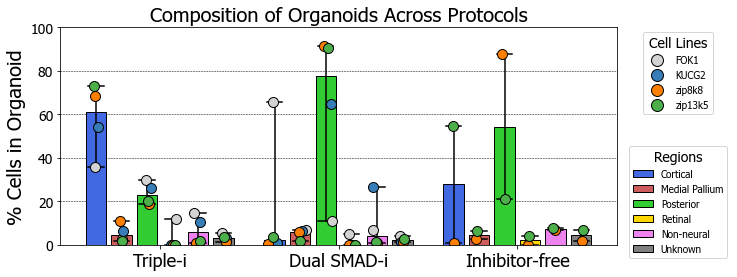

In [33]:
clrs = sns.color_palette('Set1', n_colors=10)  # a list of RGB tuples
tx_color_d = {'FOK1':'lightgray','KUCG2':clrs[1],'zip8k8':clrs[4],'zip13k5':clrs[2]}
tx_dict = {'nt':'Inhibitor-free','sbnx':'Triple-i','sbn':'Dual SMAD-i'}

plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(4,12,wspace=0.2, hspace=0.2)
ax = plt.subplot(gs[:,:10])
txs = ['sbnx','sbn','nt']
for j,tx in enumerate(txs):
    for h,reg in enumerate(regs):
        idx = j*(len(regs)+1)+h
        print(idx)
        plt.bar(idx,np.median(list(reg_percentage_dict[reg][tx].values())),edgecolor='black',color=cell_type_class_color_dict[reg],linewidth=1,zorder=-1)
        #CI plot
        plt.plot([idx-0.3,idx+0.3],[min(reg_percentage_dict[reg][tx].values()),min(reg_percentage_dict[reg][tx].values())],color='black',zorder=1,linewidth=1.5)
        plt.plot([idx-0.3,idx+0.3],[max(reg_percentage_dict[reg][tx].values()),max(reg_percentage_dict[reg][tx].values())],color='black',zorder=1,linewidth=1.5)
        plt.plot([idx,idx],[min(reg_percentage_dict[reg][tx].values()),max(reg_percentage_dict[reg][tx].values())],color='black',zorder=1,linewidth=1.5)
        for line in reg_percentage_dict[reg][tx].keys():
            plt.plot(idx+np.random.normal(0,1)*0.1,reg_percentage_dict[reg][tx][line],'o',markersize=10,markeredgecolor='k',markerfacecolor=tx_color_d[line])

for k in [0.2,0.4,0.6,0.8]:
    plt.axhline(k,linestyle='--',linewidth=0.5,color='black',zorder=-10)

plt.xticks(np.linspace((len(regs)-1)/2.,len(regs)*len(txs)+len(txs)-2-(len(regs)-1)/2.,3),[tx_dict[x] for x in txs],fontsize=18)
plt.ylabel('% Cells in Organoid',fontsize=20)
plt.ylim(0,1)
plt.xlim(plt.xlim())
plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,20,40,60,80,100],fontsize=14)
plt.title('Composition of Organoids Across Protocols',fontsize=20)

ax = plt.subplot(gs[:2,10:])
for line in ['FOK1','KUCG2','zip8k8','zip13k5']:
    cell_line_lab = plt.plot(-20,-20,'o',markersize=12,markeredgecolor='k',markerfacecolor=tx_color_d[line],label=line)

plt.xlim(0,0)
plt.ylim(0,0)
plt.axis('off')
plt.legend(loc = 'upper center',fontsize=10,title='Cell Lines',title_fontsize=14)

ax = plt.subplot(gs[2:,10:])
for h,reg in enumerate(regs):
    reg_lab = plt.bar(-10,0,edgecolor='black',color=cell_type_class_color_dict[reg],linewidth=1,zorder=-1,label=reg)

plt.xlim(0,0)
plt.ylim(0,0)
plt.axis('off')
plt.legend(loc = 'upper center',fontsize=10,title='Regions',title_fontsize=14)

plt.savefig('figures/'+line_+'/full_comp.all_regs.2.png',dpi=500,bbox_inches='tight')

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


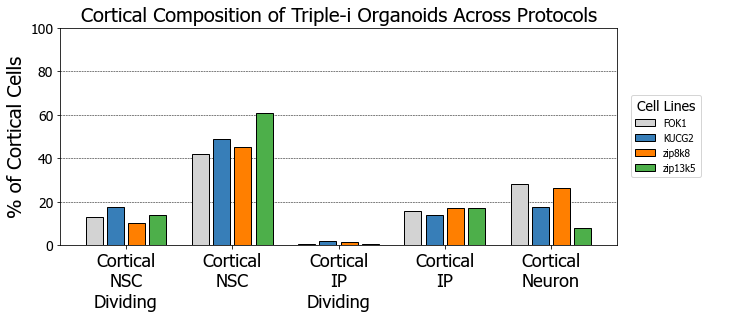

In [34]:
cell_types = ['Cortical NSC Dividing','Cortical NSC','Cortical IP Dividing','Cortical IP','Cortical Neuron']
clrs = sns.color_palette('Set1', n_colors=10)  # a list of RGB tuples
cell_type_color_dict = {}
for k,cell_type in enumerate(cell_types):
    cell_type_color_dict[cell_type] = clrs[j]

plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(4,12,wspace=0.2, hspace=0.2)
ax = plt.subplot(gs[:,:10])
lines = ['FOK1','KUCG2','zip8k8','zip13k5']
for j,cell_type in enumerate(cell_types):
    for k,line in enumerate(lines):
        idx = j*(len(lines)+1)+k
        n_cort_cells = len(adata_merged.obs[(adata_merged.obs['cell_type_class']=='Cortical') & (adata_merged.obs['line']==line)])
        n_cell_type = len(adata_merged.obs[(adata_merged.obs['cell_type']==cell_type) & (adata_merged.obs['line']==line)])
        plt.bar(idx,n_cell_type/n_cort_cells,edgecolor='black',color=tx_color_d[line],linewidth=1,zorder=-1)

for k in [0.2,0.4,0.6,0.8]:
    plt.axhline(k,linestyle='--',linewidth=0.5,color='black',zorder=-10)

plt.xticks(np.linspace((len(lines)-1)/2.,len(cell_types)*len(lines)+len(lines)-(len(cell_types)-1)/2.-0.5,len(cell_types)),
    [x.replace(' ','\n') for x in cell_types],fontsize=18)
plt.ylabel('% of Cortical Cells',fontsize=20)
plt.ylim(0,1)
plt.xlim(plt.xlim())
plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,20,40,60,80,100],fontsize=14)
plt.title('Cortical Composition of Triple-i Organoids Across Protocols',fontsize=20)

ax = plt.subplot(gs[:,10:])
for line in ['FOK1','KUCG2','zip8k8','zip13k5']:
    cell_line_lab = plt.bar(-20,-20,edgecolor='black',color=tx_color_d[line],label=line)

plt.xlim(0,0)
plt.ylim(0,0)
plt.axis('off')
plt.legend(loc = 'center left',fontsize=10,title='Cell Lines',title_fontsize=14)

plt.savefig('figures/'+line_+'/cortical_composition.png',dpi=500,bbox_inches='tight')

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


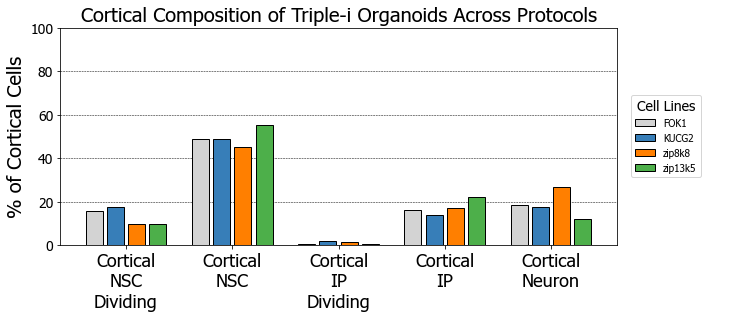

In [35]:
tx_color_d = {'FOK1':'lightgray','KUCG2':clrs[1],'zip8k8':clrs[4],'zip13k5':clrs[2]}

cell_types = ['Cortical NSC Dividing','Cortical NSC','Cortical IP Dividing','Cortical IP','Cortical Neuron']
clrs = sns.color_palette('Set1', n_colors=10)  # a list of RGB tuples
cell_type_color_dict = {}
for k,cell_type in enumerate(cell_types):
    cell_type_color_dict[cell_type] = clrs[j]

plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(4,12,wspace=0.2, hspace=0.2)
ax = plt.subplot(gs[:,:10])
lines = ['FOK1','KUCG2','zip8k8','zip13k5']
for j,cell_type in enumerate(cell_types):
    for k,line in enumerate(lines):
        idx = j*(len(lines)+1)+k
        n_cort_cells = len(adata_merged.obs[(adata_merged.obs['cell_type_class']=='Cortical') & (adata_merged.obs['line']==line) & (adata_merged.obs['tx']=='sbnx')])
        n_cell_type = len(adata_merged.obs[(adata_merged.obs['cell_type']==cell_type) & (adata_merged.obs['line']==line) & (adata_merged.obs['tx']=='sbnx')])
        plt.bar(idx,n_cell_type/n_cort_cells,edgecolor='black',color=tx_color_d[line],linewidth=1,zorder=-1)

for k in [0.2,0.4,0.6,0.8]:
    plt.axhline(k,linestyle='--',linewidth=0.5,color='black',zorder=-10)

plt.xticks(np.linspace((len(lines)-1)/2.,len(cell_types)*len(lines)+len(lines)-(len(cell_types)-1)/2.-0.5,len(cell_types)),
    [x.replace(' ','\n') for x in cell_types],fontsize=18)
plt.ylabel('% of Cortical Cells',fontsize=20)
plt.ylim(0,1)
plt.xlim(plt.xlim())
plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,20,40,60,80,100],fontsize=14)
plt.title('Cortical Composition of Triple-i Organoids Across Protocols',fontsize=20)

ax = plt.subplot(gs[:,10:])
for line in ['FOK1','KUCG2','zip8k8','zip13k5']:
    cell_line_lab = plt.bar(-20,-20,edgecolor='black',color=tx_color_d[line],label=line)

plt.xlim(0,0)
plt.ylim(0,0)
plt.axis('off')
plt.legend(loc = 'center left',fontsize=10,title='Cell Lines',title_fontsize=14)

plt.savefig('figures/'+line_+'/cortical_composition.png',dpi=500,bbox_inches='tight')

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


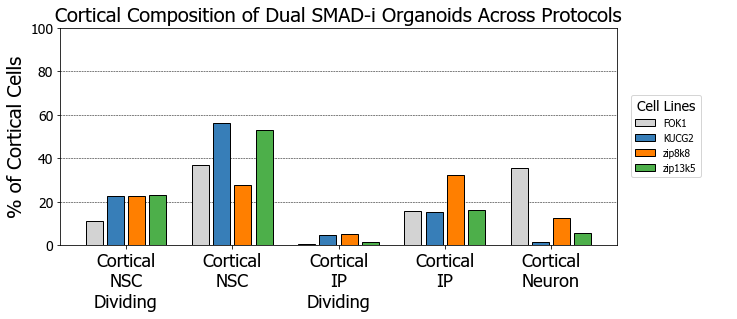

In [36]:
plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(4,12,wspace=0.2, hspace=0.2)
ax = plt.subplot(gs[:,:10])
lines = ['FOK1','KUCG2','zip8k8','zip13k5']
for j,cell_type in enumerate(cell_types):
    for k,line in enumerate(lines):
        idx = j*(len(lines)+1)+k
        n_cort_cells = len(adata_merged.obs[(adata_merged.obs['cell_type_class']=='Cortical') & (adata_merged.obs['line']==line) & (adata_merged.obs['tx']=='sbn')])
        n_cell_type = len(adata_merged.obs[(adata_merged.obs['cell_type']==cell_type) & (adata_merged.obs['line']==line) & (adata_merged.obs['tx']=='sbn')])
        plt.bar(idx,n_cell_type/n_cort_cells,edgecolor='black',color=tx_color_d[line],linewidth=1,zorder=-1)

for k in [0.2,0.4,0.6,0.8]:
    plt.axhline(k,linestyle='--',linewidth=0.5,color='black',zorder=-10)

plt.xticks(np.linspace((len(lines)-1)/2.,len(cell_types)*len(lines)+len(lines)-(len(cell_types)-1)/2.-0.5,len(cell_types)),
    [x.replace(' ','\n') for x in cell_types],fontsize=18)
plt.ylabel('% of Cortical Cells',fontsize=20)
plt.ylim(0,1)
plt.xlim(plt.xlim())
plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,20,40,60,80,100],fontsize=14)
plt.title('Cortical Composition of Dual SMAD-i Organoids Across Protocols',fontsize=20)

ax = plt.subplot(gs[:,10:])
for line in ['FOK1','KUCG2','zip8k8','zip13k5']:
    cell_line_lab = plt.bar(-20,-20,edgecolor='black',color=tx_color_d[line],label=line)

plt.xlim(0,0)
plt.ylim(0,0)
plt.axis('off')
plt.legend(loc = 'center left',fontsize=10,title='Cell Lines',title_fontsize=14)

plt.savefig('figures/'+line_+'/sbn.cortical_composition.png',dpi=500,bbox_inches='tight')

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


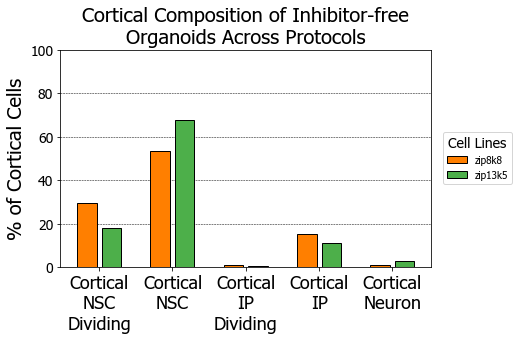

In [37]:
plt.figure(figsize=(8,4))
gs = gridspec.GridSpec(4,12,wspace=0.2, hspace=0.2)
ax = plt.subplot(gs[:,:10])
lines = ['zip8k8','zip13k5']
for j,cell_type in enumerate(cell_types):
    for k,line in enumerate(lines):
        idx = j*(len(lines)+1)+k
        n_cort_cells = len(adata_merged.obs[(adata_merged.obs['cell_type_class']=='Cortical') & (adata_merged.obs['line']==line) & (adata_merged.obs['tx']=='nt')])
        n_cell_type = len(adata_merged.obs[(adata_merged.obs['cell_type']==cell_type) & (adata_merged.obs['line']==line) & (adata_merged.obs['tx']=='nt')])
        plt.bar(idx,n_cell_type/n_cort_cells,edgecolor='black',color=tx_color_d[line],linewidth=1,zorder=-1)

for k in [0.2,0.4,0.6,0.8]:
    plt.axhline(k,linestyle='--',linewidth=0.5,color='black',zorder=-10)

plt.xticks(np.linspace((len(lines)-1)/2.,len(cell_types)*len(lines)+len(lines)-(len(cell_types)-1)/2.+2.5,len(cell_types)),
    [x.replace(' ','\n') for x in cell_types],fontsize=18)
plt.ylabel('% of Cortical Cells',fontsize=20)
plt.ylim(0,1)
plt.xlim(plt.xlim())
plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,20,40,60,80,100],fontsize=14)
plt.title('Cortical Composition of Inhibitor-free\nOrganoids Across Protocols',fontsize=20)

ax = plt.subplot(gs[:,10:])
for line in ['zip8k8','zip13k5']:
    cell_line_lab = plt.bar(-20,-20,edgecolor='black',color=tx_color_d[line],label=line)

plt.xlim(0,0)
plt.ylim(0,0)
plt.axis('off')
plt.legend(loc = 'center left',fontsize=10,title='Cell Lines',title_fontsize=14)

plt.savefig('figures/'+line_+'/nt.cortical_composition.png',dpi=500,bbox_inches='tight')

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


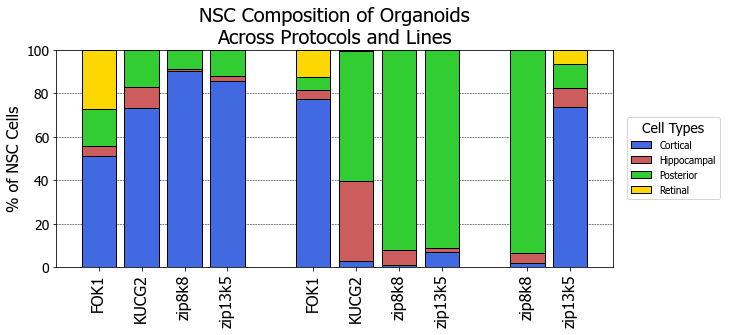

In [38]:
cell_types = ['Cortical','Hippocampal','Posterior','Retinal']
cell_type_class_color_dict['Hippocampal'] = cell_type_class_color_dict['Medial Pallium']
clusts = sorted(set(adata_merged.obs['cell_type']))
clrs = sns.color_palette('nipy_spectral', n_colors=len(cell_types))  # a list of RGB tuples
clrs_dict = {}
for j,cell in enumerate(cell_types):
    clrs_dict[cell] = clrs[j]

plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(4,12,wspace=0.2, hspace=0.2)
ax = plt.subplot(gs[:,:10])
lines = ['FOK1','KUCG2','zip8k8','zip13k5','FOK1','KUCG2','zip8k8','zip13k5','zip8k8','zip13k5']
txs = ['sbnx','sbnx','sbnx','sbnx','sbn','sbn','sbn','sbn','nt','nt']
x_iter = 0
xticks = []
for k,(line,tx) in enumerate(zip(lines,txs)):
    n_nsc_cells = len(adata_merged.obs[(adata_merged.obs['cell_type'].str.contains('NSC')) & (adata_merged.obs['line']==line) & (adata_merged.obs['tx']==tx)])
    bottom=0
    for j,cell_type in enumerate(cell_types):
        n_cell_type = len(adata_merged.obs[(adata_merged.obs['cell_type'].str.contains('NSC')) & (adata_merged.obs['cell_type'].str.contains(cell_type)) & (adata_merged.obs['line']==line) & (adata_merged.obs['tx']==tx)])
        plt.bar(x_iter,n_cell_type/n_nsc_cells,edgecolor='black',color=cell_type_class_color_dict[cell_type],linewidth=1,zorder=-1,bottom=bottom)
        bottom+=n_cell_type/n_nsc_cells
    xticks.append(x_iter)
    x_iter+=1
    if line == 'zip13k5' and tx == 'sbnx':
        x_iter += 1
    if line == 'zip13k5' and tx == 'sbn':
        x_iter += 1

#plt.xticks(xticks,[line+'\n'+'('+tx_dict[tx]+')' for line,tx in zip(lines,txs)],rotation=90,fontsize=16)
plt.xticks(xticks,[line for line,tx in zip(lines,txs)],rotation=90,fontsize=16)

for k in [0.2,0.4,0.6,0.8]:
    plt.axhline(k,linestyle='--',linewidth=0.5,color='black',zorder=-10)

plt.ylabel('% of NSC Cells',fontsize=16)
#plt.ylim(0,1)
plt.xlim(plt.xlim())
plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,20,40,60,80,100],fontsize=14)
plt.title('NSC Composition of Organoids\nAcross Protocols and Lines',fontsize=20)

ax = plt.subplot(gs[:,10:])
for cell_type in cell_types:
    cell_line_lab = plt.bar(-20,-20,edgecolor='black',color=cell_type_class_color_dict[cell_type],label=cell_type)

plt.xlim(0,0)
plt.ylim(0,0)
plt.axis('off')
plt.legend(loc = 'center left',fontsize=10,title='Cell Types',title_fontsize=14)

plt.savefig('figures/'+line_+'/nsc_composition.stacked.all.png',dpi=500,bbox_inches='tight')

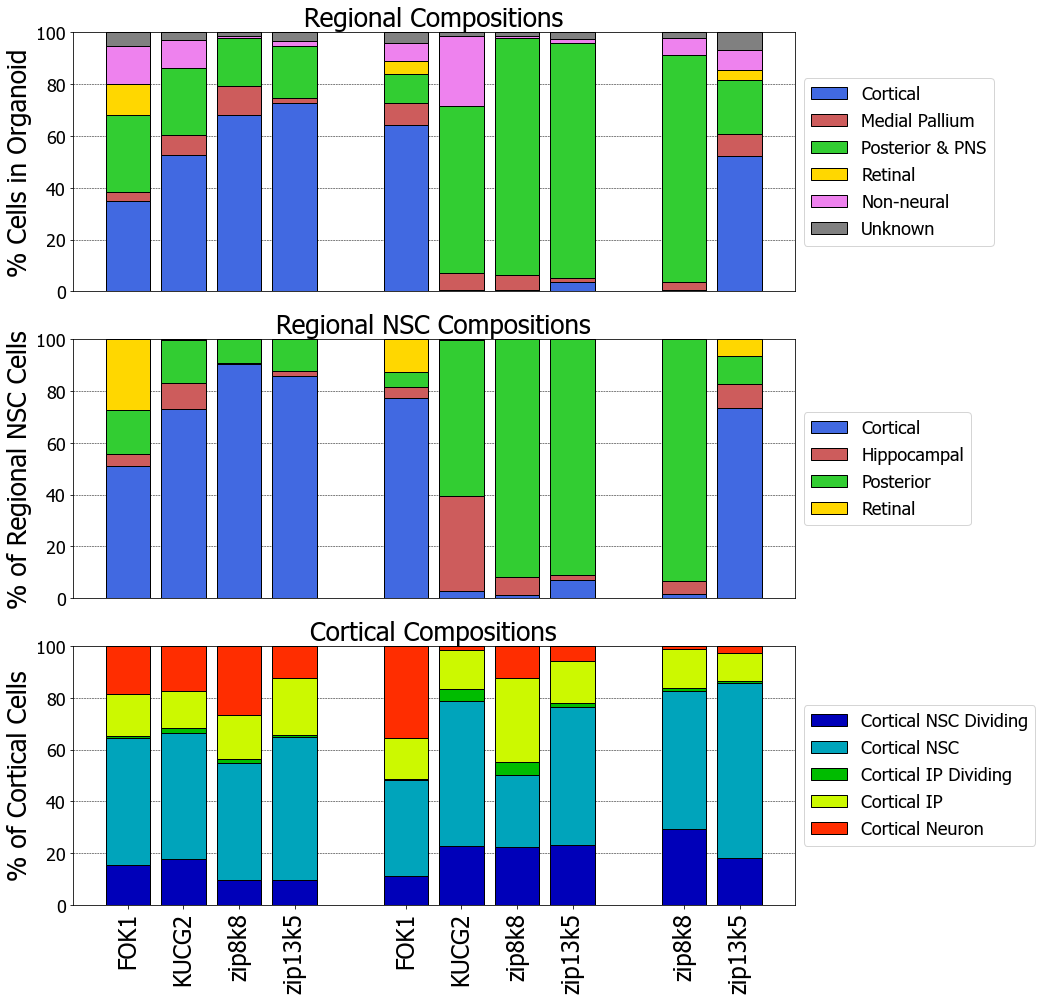

In [39]:
plt.figure(figsize=(14,14))
ax = plt.subplot(311)
regs = ['Cortical','Medial Pallium','Posterior','Retinal','Non-neural','Unknown']
bottoms = {}
for kk,reg in enumerate(regs):
    xticks = []
    xtick_locs = []
    x_iter = 0
    for j,tx in enumerate(['sbnx','sbn','nt']):
        if tx == 'nt': txs = ['zip8k8','zip13k5']
        else: txs = ['FOK1','KUCG2','zip8k8','zip13k5']
        for k,line_iter in enumerate(txs):
            if line_iter not in bottoms: 
                bottoms[line_iter]={}
            if tx not in bottoms[line_iter]:
                bottoms[line_iter][tx] = 0
            adata_merged_sub = adata_merged_no_doublets[adata_merged_no_doublets.obs['line']==line_iter]
            len_tx = float(len(adata_merged_sub.obs[adata_merged_sub.obs['tx']==tx]))
            for clust in [reg]:#ordered_cell_type_class:
                perc_cells = len(adata_merged_sub.obs[(adata_merged_sub.obs['tx']==tx) & (adata_merged_sub.obs['cell_type_class']==clust)])/len_tx
                plt.bar(x_iter+k,perc_cells,bottom=bottoms[line_iter][tx],color=cell_type_class_color_dict[clust],width=0.8,edgecolor='black',linewidth=1)
                bottoms[line_iter][tx] += perc_cells
            xtick_locs.append(x_iter + k)
        x_iter += k+2

plt.xticks([])
for k in [0.2,0.4,0.6,0.8]:
    plt.axhline(k,linestyle='--',linewidth=0.5,color='black',zorder=-10)

plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,20,40,60,80,100],fontsize=18)

plt.ylabel('% Cells in Organoid',fontsize=26)
plt.xlim(plt.xlim())
plt.ylim(0,1)

for clust in regs:
    if clust == 'Posterior': label='Posterior & PNS'
    else: label=clust
    plt.bar(-100,0,color=cell_type_class_color_dict[clust],label=label,edgecolor='black',linewidth=1)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=18)

plt.tight_layout()
plt.title('Regional Compositions',fontsize=26)



cell_types = ['Cortical','Hippocampal','Posterior','Retinal']
cell_type_class_color_dict['Hippocampal'] = cell_type_class_color_dict['Medial Pallium']
clusts = sorted(set(adata_merged.obs['cell_type']))
clrs = sns.color_palette('nipy_spectral', n_colors=len(cell_types))  # a list of RGB tuples
clrs_dict = {}
for j,cell in enumerate(cell_types):
    clrs_dict[cell] = clrs[j]

ax = plt.subplot(312)
lines = ['FOK1','KUCG2','zip8k8','zip13k5','FOK1','KUCG2','zip8k8','zip13k5','zip8k8','zip13k5']
txs = ['sbnx','sbnx','sbnx','sbnx','sbn','sbn','sbn','sbn','nt','nt']
x_iter = 0
xticks = []
for k,(line,tx) in enumerate(zip(lines,txs)):
    n_nsc_cells = len(adata_merged.obs[(adata_merged.obs['cell_type'].str.contains('NSC')) & (adata_merged.obs['line']==line) & (adata_merged.obs['tx']==tx)])
    bottom=0
    for j,cell_type in enumerate(cell_types):
        n_cell_type = len(adata_merged.obs[(adata_merged.obs['cell_type'].str.contains('NSC')) & (adata_merged.obs['cell_type'].str.contains(cell_type)) & (adata_merged.obs['line']==line) & (adata_merged.obs['tx']==tx)])
        plt.bar(x_iter,n_cell_type/n_nsc_cells,edgecolor='black',color=cell_type_class_color_dict[cell_type],linewidth=1,zorder=-1,bottom=bottom)
        bottom+=n_cell_type/n_nsc_cells
    xticks.append(x_iter)
    x_iter+=1
    if line == 'zip13k5' and tx == 'sbnx':
        x_iter += 1
    if line == 'zip13k5' and tx == 'sbn':
        x_iter += 1

plt.xticks([])
plt.xlim(plt.xlim())
for cell_type in cell_types:
    cell_line_lab = plt.bar(-20,0,edgecolor='black',color=cell_type_class_color_dict[cell_type],label=cell_type)

for k in [0.2,0.4,0.6,0.8]:
    plt.axhline(k,linestyle='--',linewidth=0.5,color='black',zorder=-10)

plt.ylabel('% of Regional NSC Cells',fontsize=26)

plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,20,40,60,80,100],fontsize=18)
plt.title('Regional NSC Compositions',fontsize=26)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=18)

plt.tight_layout()


cell_types = ['Cortical NSC Dividing','Cortical NSC','Cortical IP Dividing','Cortical IP','Cortical Neuron']
clrs = sns.color_palette('nipy_spectral', n_colors=len(cell_types))  # a list of RGB tuples
cell_type_color_dict = {}
for k,cell_type in enumerate(cell_types):
    cell_type_color_dict[cell_type] = clrs[k]

ax = plt.subplot(313)
lines = ['FOK1','KUCG2','zip8k8','zip13k5','FOK1','KUCG2','zip8k8','zip13k5','zip8k8','zip13k5']
txs = ['sbnx','sbnx','sbnx','sbnx','sbn','sbn','sbn','sbn','nt','nt']
x_iter = 0
xticks = []
for k,(line,tx) in enumerate(zip(lines,txs)):
    n_cort_cells = len(adata_merged.obs[(adata_merged.obs['cell_type_class']=='Cortical') & (adata_merged.obs['line']==line) & (adata_merged.obs['tx']==tx)])
    bottom=0
    for j,cell_type in enumerate(cell_types):
        n_cell_type = len(adata_merged.obs[(adata_merged.obs['cell_type']==cell_type) & (adata_merged.obs['line']==line) & (adata_merged.obs['tx']==tx)])
        plt.bar(x_iter,n_cell_type/n_cort_cells,edgecolor='black',color=cell_type_color_dict[cell_type],linewidth=1,zorder=-1,bottom=bottom)
        bottom+=n_cell_type/n_cort_cells
    xticks.append(x_iter)
    x_iter+=1
    if line == 'zip13k5' and tx == 'sbnx':
        x_iter += 1
    if line == 'zip13k5' and tx == 'sbn':
        x_iter += 1

plt.xticks(xtick_locs,['FOK1','KUCG2','zip8k8','zip13k5',
    'FOK1','KUCG2','zip8k8','zip13k5','zip8k8','zip13k5',],fontsize=24,rotation=90)

for k in [0.2,0.4,0.6,0.8]:
    plt.axhline(k,linestyle='--',linewidth=0.5,color='black',zorder=-10)

plt.ylabel('% of Cortical Cells',fontsize=26)
plt.ylim(0,1)
plt.xlim(plt.xlim())
plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,20,40,60,80,100],fontsize=18)
plt.title('Cortical Compositions',fontsize=26)
for cell_type in cell_types:
    cell_line_lab = plt.bar(-20,0,edgecolor='black',color=cell_type_color_dict[cell_type],label=cell_type)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=18)
plt.tight_layout()
plt.savefig('figures/'+line_+'/stacked_bars_all.png',dpi=500,bbox_inches='tight')